In [27]:
# Clone our GitHub repository into the Colab environment
!git clone https://github.com/GSebs/ml-health-forecasting-transformer.git

%cd ml-health-forecasting-transformer

!pip install -r requirements.txt

fatal: destination path 'ml-health-forecasting-transformer' already exists and is not an empty directory.
/content/ml-health-forecasting-transformer/ml-health-forecasting-transformer


In [28]:
import torch
import numpy as np
import os
from torch.utils.data import DataLoader, TensorDataset 
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
DATA_DIR = 'data'
ARTIFACTS_DIR = os.path.join(DATA_DIR,'artifacts') 
#instead of feeding the gpu the entire sequence at once, we break it down into batch sizes of 64
#preventing memory overload on the GPU
BATCH_SIZE = 64

X_train = np.load(os.path.join(ARTIFACTS_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(ARTIFACTS_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(ARTIFACTS_DIR,'X_val.npy'))
y_val = np.load(os.path.join(ARTIFACTS_DIR, 'y_val.npy'))

In [38]:
'''
NNs in pytorch can't read numpy arrays so we have to covert them into tensors 
gpus are optimized for float32 to make training faster 
and fit larger models (but numpy arrays default to float64 which takes 2x the memory)
so we have to specify the dtype when converting to tensors
'''

train_features = torch.tensor(X_train, dtype=torch.float32)
train_targets = torch.tensor(y_train, dtype=torch.float32)
val_features = torch.tensor(X_val, dtype=torch.float32)
val_targets = torch.tensor(y_val,dtype=torch.float32)

#TensorDataset acts as a zipper to link features and targets together so when we shuffle the features and targets stay aligned
train_dataset = TensorDataset(train_features, train_targets)
val_dataset = TensorDataset(val_features, val_targets)

#We use DataLoader to feed the data into the model in batches
#Specifcally we are able to send chunks of the data and shuffel up the cycles randomly for each engine to prevent overfitting
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) #No need to shuffle validation data to its easier to visualize preformance

print(f"Data loaded. Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

Data loaded. Training batches: 222, Validation batches: 56


In [36]:
class LSTMBaseline(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim=50, num_layers=2, output_dim=1, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]
        prediction = self.fc(last_out)

        return prediction
    
    def training_step(self, batch, batch_idx):
        x,y = batch
        y_pred = self(x)

        loss = self.criterion(y_pred, y.view(-1,1))
        self.log('train_loss', loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x,y = batch
        y_pred = self(x)

        loss = self.criterion(y_pred, y.view(-1,1))
        self.log('val_loss', loss)

        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


In [44]:
from pytorch_lightning.loggers import CSVLogger


input_dim = X_train.shape[2] 


model = LSTMBaseline(input_dim=input_dim)


csv_logger = CSVLogger("training_logs", name="lstm_baseline")


trainer = pl.Trainer(
    max_epochs=20, 
    accelerator='gpu', 
    devices=1,
    enable_progress_bar=True,
    logger=csv_logger 
)


print("Starting Baseline Training with CSV Logging...")
trainer.fit(model, train_loader, val_loader)
print("Training Complete.")

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 34.2 K | train
1 | fc        | Linear  | 51     | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
34.3 K    Trainable params
0         Non-trainable params
34.3 K    Total params
0.137     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Starting Baseline Training with CSV Logging...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Training Complete.


Loading metrics from: training_logs/lstm_baseline/version_1/metrics.csv


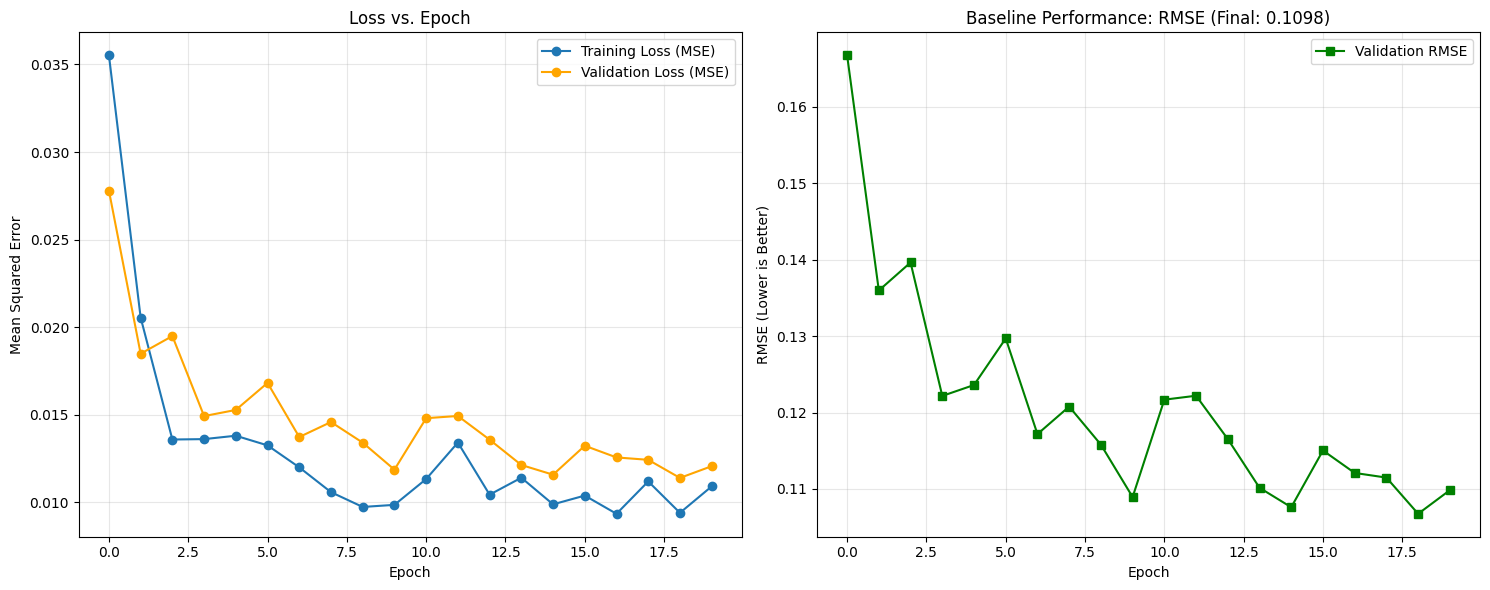

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob


log_dir = 'training_logs/lstm_baseline'


versions = glob.glob(os.path.join(log_dir, 'version_*'))

if len(versions) > 0:

    latest_version = max(versions, key=os.path.getmtime)
    metrics_path = os.path.join(latest_version, 'metrics.csv')
    print(f"Loading metrics from: {metrics_path}")
    

    metrics_df = pd.read_csv(metrics_path)
    

    epoch_metrics = metrics_df.groupby('epoch').mean().reset_index()
    

    if 'val_loss' in epoch_metrics.columns:
        epoch_metrics['val_rmse'] = epoch_metrics['val_loss'] ** 0.5
    

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    if 'train_loss' in epoch_metrics.columns:
        plt.plot(epoch_metrics['epoch'], epoch_metrics['train_loss'], label='Training Loss (MSE)', marker='o')
    if 'val_loss' in epoch_metrics.columns:
        plt.plot(epoch_metrics['epoch'], epoch_metrics['val_loss'], label='Validation Loss (MSE)', marker='o', color='orange')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True, alpha=0.3)


    plt.subplot(1, 2, 2)
    if 'val_rmse' in epoch_metrics.columns:
        plt.plot(epoch_metrics['epoch'], epoch_metrics['val_rmse'], label='Validation RMSE', color='green', marker='s')
        final_rmse = epoch_metrics['val_rmse'].iloc[-1]
        plt.title(f'Baseline Performance: RMSE (Final: {final_rmse:.4f})')
    else:
        plt.title('RMSE Not Available')
        
    plt.xlabel('Epoch')
    plt.ylabel('RMSE (Lower is Better)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
else:
    print(f"No logs found in {log_dir}. Did you run the training cell above?")